In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import pandas as pd
from datetime import datetime
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from scipy.stats import multivariate_normal
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
import seaborn as sns
from datetime import date
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 100})

C:\Users\DE118048\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# 1. Bayesian Theorem

## 1.1 Task

$$
P(I|E) = P(E|I)\frac{P(I)}{P(E)}, where
$$

$ P(I) - \mbox{probablity that man is innocent not depending on the test result} $ \
$ P(E) - \mbox{prior probablity that test is observed} $ \
$ P(E|I) - \mbox{probability that test is observed given that man is innocent (false positive result)} $
$ P(I|E) - \mbox{probability that man is innocent given despite the test is observed} $

$ \mbox{We see that } P(E|I) \mbox{ is small - that prosecitor evaluated. Prosecutor mistakes when tells that }  P(I|E) \mbox{ is small - that prosecutor should evaluate.} $ \
$ \mbox{In fact } P(E|I) \mbox{ and} P(I|E) \mbox{ are different from each other.} $ \
$ \mbox{Equation above shows that small } P(E|I) \mbox{ does not imply small } P(I|E) \mbox{ in case of big value of } P(I) \mbox{ and small value } P(E). $ 
$ \mbox{I.E if in other case man can be innocent and hardly somebody presents observed evidence.} $

## 1.2 Task

$$
P(G|E) = P(E|G)\frac{P(G)}{P(E)}, where
$$

$ P(G) - \mbox{probablity that man is guilty not depending on the test result} $ \
$ P(E) - \mbox{prior probablity that test is observed} $ \
$ P(E|G) - \mbox{probability that test is observed given that man is guilty} $ \
$ P(G|E) - \mbox{probability that man is innocent given despite the test is observed} $

$ \mbox{The defender tries to evaluate} P(G|E). $ \
$ \mbox{The defender evaluated P(G|E) given that we consider all people in the city are suspects}. $ \
$ \mbox{In defender's calculation prior guilty probability is not correct. If for example police presents list of 10 suspects that had access} $ 
$ \mbox{to crime place then it would not be logically to suppose that test that gives 1/1000000 on success would change prior probablity from 1/10 to 1/1000000.} $  

## 1.3 Task

In [2]:
def aposterior_positive_prob(false_positive, false_negative):

    return  (1 - false_negative) * 0.01 / ((1 - false_negative) * 0.01 + false_positive * 0.99) 

def aposterior_negative_prob(false_positive, false_negative):

    return false_negative * 0.01 / (false_negative * 0.01 + (1 - false_positive) * 0.99)

NameError: name 'changing_fp' is not defined

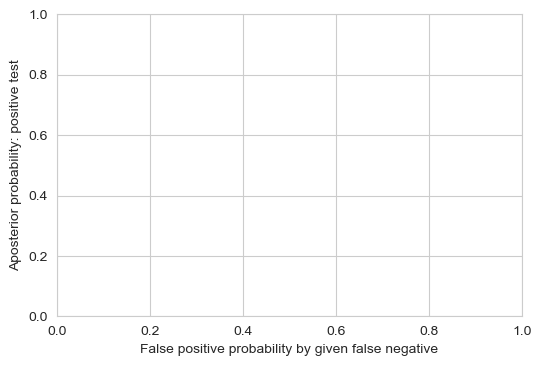

In [3]:
false_pos = lambda x: aposterior_positive_prob(false_positive=0.05, false_negative=x)
false_neg = lambda x: aposterior_negative_prob(false_positive=x,    false_negative=0.05)
x = np.linspace(0, 0.05, 1000)
plt.ylabel("Aposterior probability: positive test")
plt.xlabel("False positive probability by given false negative")
plt.plot(x, changing_fp(x), label="False positive")
plt.plot(x, changing_fn(x), label="False negative")
plt.legend()
plt.show()

$ \mbox{We can see that aposterior_positive_prob changes significantly with the growth of false_positive value} $ \
$ \mbox{and vice versa  aposterior_negative_prob changes not much, so conclusion to concentrate on reducing false_positives} $

# 2. Linear Regression

### 2.1 Train Linear Model y ~ exp(linear function(x))

### Total Cases

In [ ]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url)

In [ ]:
target = 'total_cases' 
#target = 'new_cases' 

In [ ]:
date_format = "%Y-%m-%d"
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '2020-03-03']
df.loc[df["new_cases"] == 0, "new_cases"] = 1
df = df.reset_index(drop=True)
df['current_date'] = (df['date'] - df['date'].min()).dt.days + 1

In [ ]:
russia = df[(df['location'] == 'Russia')].reset_index(drop=True)

In [ ]:
train = df[(df['location'] == 'Russia') & (df['current_date'] <= 50)].reset_index(drop=True)
test = df[(df['location'] == 'Russia') & (df['current_date'] > 50)].reset_index(drop=True)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train['date'], train['total_cases'], label='Total Cases')
plt.plot(train['date'], train['new_cases'], label='New Cases')
plt.title('Total cases and New Cases')
plt.xlabel('Date')
plt.ylabel(target)
plt.show()

In [ ]:
regr = linear_model.LinearRegression()
X = train['current_date'].values.reshape(-1, 1)
ln_Y = np.log(train[target]).values.reshape(-1, 1)
regr.fit(X,ln_Y)
train['predicted'] = train['current_date'] * float(regr.coef_) + float(regr.intercept_)

### 2.2 Aposterior Distribution

In [ ]:
sigma_noise = np.std(train['predicted'] - np.log(train[target]))

In [ ]:
def bayesian_update(mu, sigma, x, y, sigma_noise=sigma_noise):
    x_matrix = np.array([[1, *x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [ ]:
N = 250
cur_mu, cur_sigma = np.array([0, 0]), 10 * np.array([[1, 0], [0, 1]])

for i in range(50):
    px, py = i + 1, np.log(np.array(train[target][i]))
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)

X = np.linspace(*plot_lims[0], N)
Y = np.linspace(*plot_lims[1], N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

plt.figure(figsize=(8, 8))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.title('Aposterior Distribution: ' + target)
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

In [ ]:
print('Aposterior Distribution: ', cur_mu)

### 2.3 Sample exp: Predicitions on 1st May, 1st June, 1st September

In [ ]:
def myplot_sample_lines(mu, sigma, xs=np.arange(0, 100), n=200, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
plt.xlabel("current date", fontsize=25)
plt.ylabel("total cases", fontsize=25)
myplot_sample_lines(cur_mu, cur_sigma, n=50, points=[train['current_date'].values, train['total_cases'].values])

In [ ]:
# Draw result
def plot_predictions(xs, mu, x, train_points, test_points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlabel('current_date', fontsize=15)
    plt.ylabel(target, fontsize=15)
    ax.set_xlim((xs[0], xs[-1]))
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(train_points[0], train_points[1], marker='*', color="blue", s=100, label="Train")
    ax.scatter(test_points[0], test_points[1], marker='*', color="black", s=100, label="Test")
    ax.legend(fontsize=legend_fontsize)

In [ ]:
# Sample lines and give statistics on predictions
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0] + w[1]*xs)
    return res

In [ ]:
xs = np.arange(0, 100)
x = sample_statistics(cur_mu, cur_sigma, xs, n=200)
plot_predictions(xs, cur_mu, x, [train['current_date'].values, train[target].values], [test['current_date'].values, test[target].values])

In [ ]:
def myplot_sample_lines(mu, sigma, xs=np.arange(0, 70), n=200, points=None):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        y = np.exp(w[0] + w[1]*xs)
        plt.plot(xs, y, 'k-', lw=.4, alpha=0.3)
        res[i,:] = y
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    return res[:,-1]

In [ ]:
may = myplot_sample_lines(cur_mu, cur_sigma, xs=np.arange(1, (date(2020,5,1) - date(2020,3,3)).days + 1), n=1000, points=[train['current_date'].values, train[target].values])
plt.title("1st May")
plt.xlabel("current day")
plt.ylabel(target)
plt.show()
june = myplot_sample_lines(cur_mu, cur_sigma, xs=np.arange(1, (date(2020,6,1) - date(2020,3,3)).days + 1), n=1000, points=[train['current_date'].values, train[target].values])
plt.title("1st June")
plt.xlabel("current day")
plt.ylabel(target)
plt.show()
september = myplot_sample_lines(cur_mu, cur_sigma, xs=np.arange(1, (date(2020,9,1) - date(2020,3,3)).days + 1), n=1000, points=[train['current_date'].values, train[target].values])
plt.title("1st September")
plt.xlabel("current day")
plt.ylabel(target)
plt.show()

In [ ]:
plt.hist(may, bins=100)
plt.title('1st May Distribution')
plt.show()
plt.hist(june, bins=100)
plt.title('1st June Distribution')
plt.show()
plt.hist(september, bins=100)
plt.title('1st September Distribution')
plt.show()

In [ ]:
print(f" Average number of total cases on the 1st of May is {may.mean()}")
print(f" Average number of total cases on the 1st of June is {june.mean()}")
print(f" Average number of total cases on the 1st of September is {september.mean()}")

# 3. Linear Regression: second step polynom 

### 3.1 Approach for training

$ \mbox{ 1. The derivative from distibution function is density distribution function } $ \
$ \mbox{ 2. Target total cases is cumulative function from target new cases } $ \
$ \mbox{ 3. Take logarithm from density function,  this will give us polynom of second step: } ax^2 + bx + c $ \
$ \mbox{ 4. So in that case we can train our model with sigmoid where target would be cumulative function of new cases  } \ $

### 2.2 Aposterior Distribution

In [ ]:
target = 'new_cases'

In [ ]:
regr = linear_model.LinearRegression()
X = train['current_date']
X = np.array(list(zip(X, X**2)))
ln_Y = np.log(train[target]).values.reshape(-1, 1)
regr.fit(X,ln_Y)

In [ ]:
train['predicted'] = train['current_date'] * float(regr.coef_[:,0]) + (train['current_date'] ** 2) * float(regr.coef_[:,1]) + float(regr.intercept_)
train['cumulative_predicted'] = np.cumsum(train['predicted'])

In [ ]:
sigma_noise = np.std(train['predicted'] - np.log(train[target]))

In [ ]:
cur_mu, cur_sigma = np.array([0, 0, 0]), 10 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

for i in range(50):
    px, py = X[i], np.log(np.array(train[target][i]))
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)

In [ ]:
print('Aposterior Distribution: ', cur_mu)

In [ ]:
def plot_predictions(xs, mu, sigma, n, train_points, test_points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((0, 5e6))
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        y = np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))
        ax.plot(xs, y, 'k-', lw=.4, alpha=0.3)
        res[i,:] = y
    ax.plot(xs, np.cumsum(np.exp(mu[2]*(xs**2) + mu[1]*xs + mu[0])), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.mean(res, axis=0) - np.std(res, axis=0), np.mean(res, axis=0) + np.std(res, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(train_points[0], train_points[1], marker='*', color="blue", s=100, label="train data")
    ax.scatter(test_points[0], test_points[1], marker='*', color="green", s=100, label="test data")
    ax.legend(fontsize=legend_fontsize)
    return res[:,-1]

num_days = 350
xs = np.arange(0, num_days)
x_train = np.arange(0, train_size)
dist = plot_predictions(xs, cur_mu, cur_sigma, n=1000, train_points=[x_train, df_train["total_cases"].values], test_points=[x_test[:num_days - 50], df_test["total_cases"].values[:num_days - 50]])